In [29]:
""" **Description**
    Diamondback is package which provides Digital Signal Processing ( DSP )
    solutions, organized in the form of commons, filters, interfaces, models, and
    transforms.

    Diamondback complements Artificial Intelligence ( AI ) frameworks, by
    defining components which analyze, filter, extract, model, and transform
    data into forms which are useful in applications including pattern
    recognition, feature extraction, and optimization.

    Diamondback also facilitates classical signal processing solutions
    including communications, modeling, signal identification and extraction,
    and noise cancellation.
    
    **License**
        `BSD-3C.  <https://github.com/larryturner/diamondback/blob/master/license>`_
        © 2018 - 2021 Larry Turner, Schneider Electric Industries SAS. All rights reserved.
    
    **Author**
        Larry Turner, Schneider Electric, Analytics & AI, 2018-01-23.
"""

from diamondback import Log
from diamondback import FirFilter, IirFilter, ComplexBandPassFilter, ComplexExponentialFilter
from diamondback import ComplexFrequencyFilter, DerivativeFilter, GoertzelFilter, IntegralFilter
from diamondback import PolynomialRateFilter, PolyphaseRateFilter, WindowFilter
from diamondback import DiversityModel, PrincipalComponentModel
from diamondback import ComplexTransform, FourierTransform, PowerSpectrumTransform, WaveletTransform
from PIL import Image
from typing import Any
import IPython
import ipywidgets
import math
import matplotlib    
import matplotlib.pyplot
import numpy

def label( axes : Any, title : str = '', x : str = '', y : str = '', grid : bool = True ) -> None :

    """ Label plot title and axes, autoscale, and show grid.
        
        Arguments :
            axes : Any.
            title : str.
            x : str - x label.
            y : str - y label.
            grid : bool.
    """

    axes.set_xlabel( x )
    axes.set_ylabel( y )
    axes.set_title( title )
    axes.grid( grid )
    axes.autoscale( enable = True, axis = 'both', tight = True )
    

In [30]:
@ipywidgets.interact( )
def interface( style = ipywidgets.Dropdown( description = 'Style', value = 'Hann', options = [ 'Blackman', 'Hamming', 'Hann', 'Kaiser' ], layout = { 'width' : '340px' } ),
               frequency = ipywidgets.FloatSlider( description = 'Frequency', value = 0.1, min = 0.001, max = 0.999, step = 0.001, readout_format = '0.3f', layout = { 'width' : '420px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 64, min = 1, max = 4096, step = 1, layout = { 'width' : '420px' } ),
               count = ipywidgets.IntSlider( description = 'Count', value = 1, min = 1, max = 16, step = 1, layout = { 'width' : '420px' } ),
               complement = ipywidgets.IntSlider( description = 'Complement', value = False, min = False, max = True, layout = { 'width' : '420px' } ) ) :
    
    """ Finite Impulse Response Filter.
        
        Arguments :
            style : str - in ( 'Blackman', 'Hamming', 'Hann', 'Kaiser' ).
            frequency : float - relative to Nyquist in ( 0.0, 1.0 ).
            order : int.
            count : int.
            complement : bool.
    """

    try :
        firfilter = FirFilter( style = style, frequency = frequency, order = order, count = count, complement = complement )
    except Exception as ex :
        Log.write( 'ERROR', ex )
        return
    widget = [ ipywidgets.Dropdown( description = 'b', value = str( firfilter.b[ 0 ] ), options = [ str( x ) for x in firfilter.b ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 2, 2, sharex = False, sharey = False, figsize = ( 18, 18 ) )[ 1 ]
    
    # Coefficients
    
    length = 1024
    n = numpy.linspace( 0.0, order, order + 1 )
    axes[ 0, 0 ].plot( n, numpy.zeros( order + 1 ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 0 ].plot( n, firfilter.b, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    label( axes[ 0, 0 ], r'$Coefficients$', r'$n$', r'$\vec{b_{n}}$' )
    
    # Roots
    
    plot = [ ]
    p, z = firfilter.roots( count )
    ii = numpy.where( z.real > 10.0 )[ 0 ]
    z[ ii ] = 10.0 * numpy.sign( z[ ii ].real )
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ 0, 1 ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    plot.append( axes[ 0, 1 ].plot( p.real, p.imag, linestyle = 'None', marker = '+', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0, 1 ].plot( z.real, z.imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 1 ].legend( plot, ( r'$\vec{p_{n}}$', r'$\vec{z_{n}}$' ), loc = 'upper right' )
    label( axes[ 0, 1 ], r'$Roots$', r'$real$', r'$imag$' )
    
    # Response
    
    h, f = firfilter.response( count = count )
    h = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) )
    ii, jj, = int( numpy.round( len( h ) // 2 * ( 1.0 - frequency ) ) ), int( numpy.round( len( h ) // 2 * ( 1.0 + frequency ) ) )
    axes[ 1, 0 ].plot( f, -3.0 * numpy.ones( len( h ) ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( -frequency, h[ ii ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 0 ].plot( frequency, h[ jj ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    label( axes[ 1, 0 ], r'$Response$', r'$f$', r'$H_{f}\ dB$' )
    
    # Delay
    
    d, f = firfilter.delay( count = count )
    d = numpy.round( d * 10.0 ) / 10.0  
    axes[ 1, 1 ].plot( -frequency, d[ ii ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 1 ].plot( frequency, d[ jj ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 1 ].plot( f, d, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    label( axes[ 1, 1 ], r'$Delay$', r'$f$', r'$\tau_{f}\ n$' )
    matplotlib.pyplot.show( )
    

interactive(children=(Dropdown(description='Style', index=2, layout=Layout(width='340px'), options=('Blackman'…

In [31]:
@ipywidgets.interact( )
def interface( style = ipywidgets.Dropdown( description = 'Style', value = 'Butterworth', options = [ 'Bessel', 'Butterworth', 'Chebyshev' ], layout = { 'width' : '340px' } ),
               frequency = ipywidgets.FloatSlider( description = 'Frequency', value = 0.1, min = 0.001, max = 0.999, step = 0.001, readout_format = '0.3f', layout = { 'width' : '420px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 6, min = 1, max = 16, step = 1, layout = { 'width' : '420px' } ),
               count = ipywidgets.IntSlider( description = 'Count', value = 1, min = 1, max = 16, step = 1, layout = { 'width' : '420px' } ),
               complement = ipywidgets.IntSlider( description = 'Complement', value = False, min = False, max = True, layout = { 'width' : '420px' } ) ) :
    
    """ Infinite Impulse Response Filter.
        
        Arguments :
            style : str - in ( 'Bessel', 'Butterworth', 'Chebyshev' ).
            frequency : float - relative to Nyquist in ( 0.0, 1.0 ).
            order : int.
            count : int.
            complement : bool.
    """
    
    iirfilter = IirFilter( style = style, frequency = frequency, order = order, count = count, complement = complement )
    widget = [ ipywidgets.Dropdown( description = 'a', value = str( iirfilter.a[ 0 ] ), options = [ str( x ) for x in iirfilter.a ], layout = { 'width' : '340px' } ),
               ipywidgets.Dropdown( description = 'b', value = str( iirfilter.b[ 0 ] ), options = [ str( x ) for x in iirfilter.b ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 2, 2, sharex = False, sharey = False, figsize = ( 18, 18 ) )[ 1 ]
    
    # Coefficients

    plot = [ ]
    length = 1024
    n = numpy.linspace( 0.0, order, order + 1 )    
    axes[ 0, 0 ].plot( n, numpy.zeros( order + 1 ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 0 ].bar( n, iirfilter.a, color = [ 0.8, 0.2, 0.2 ], width = 0.006 * ( order + 1 ) )
    axes[ 0, 0 ].bar( n, iirfilter.b, color = [ 0.2, 0.2, 0.8 ], width = 0.006 * ( order + 1 ) )
    plot.append( axes[ 0, 0 ].plot( n, iirfilter.a, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0, 0 ].plot( n, iirfilter.b, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 0 ].legend( plot, ( r'$\vec{a_{n}}$', r'$\vec{b_{n}}$' ), loc = 'upper right' )
    label( axes[ 0, 0 ], r'$Coefficients$', r'$n$' )
    
    # Roots

    plot = [ ]
    p, z = iirfilter.roots( count )
    ii = numpy.where( z.real > 10.0 )[ 0 ]
    z[ ii ] = 10.0 * numpy.sign( z[ ii ].real )
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ 0, 1 ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    plot.append( axes[ 0, 1 ].plot( p.real, p.imag, linestyle = 'None', marker = '+', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0, 1 ].plot( z.real, z.imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 1 ].legend( plot, ( r'$\vec{p_{n}}$', r'$\vec{z_{n}}$' ), loc = 'upper right' )
    label( axes[ 0, 1 ], r'$Roots$', r'$real$', r'$imag$' )
    
    # Response
    
    h, f = iirfilter.response( count = count )
    h = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) )
    ii, jj, = int( numpy.round( len( h ) // 2 * ( 1.0 - frequency ) ) ), int( numpy.round( len( h ) // 2 * ( 1.0 + frequency ) ) )
    axes[ 1, 0 ].plot( f, -3.0 * numpy.ones( len( h ) ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( -frequency, h[ ii ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 0 ].plot( frequency, h[ jj ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    label( axes[ 1, 0 ], r'$Response$', r'$f$', r'$H_{f}\ dB$' )

    # Delay
    
    d, f = iirfilter.delay( count = count )
    d = numpy.round( d * 10.0 ) / 10.0  
    axes[ 1, 1 ].plot( -frequency, d[ ii ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 1 ].plot( frequency, d[ jj ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 1 ].plot( f, d, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    label( axes[ 1, 1 ], r'$Delay$', r'$f$', r'$\tau_{f}\ n$' )
    matplotlib.pyplot.show( )
    

interactive(children=(Dropdown(description='Style', index=1, layout=Layout(width='340px'), options=('Bessel', …

In [32]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ -0.05, 0.1 ], min = -1.0, max = 0.99, step = 0.01, layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),               
               derivative = ipywidgets.IntSlider( description = 'Derivative', value = 1, min = 1, max = 3, step = 1, layout = { 'width' : '420px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 2, min = 0, max = 8, step = 2, layout = { 'width' : '420px' } ) ) :
    
    """ Derivative Filter.    
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            derivative : int.
            order : int.
    """
    
    order = int( max( min( order, 2.0 ** ( derivative + 1 ) ), 2.0 ** ( derivative - 1 ) ) )
    derivativefilter = DerivativeFilter( derivative, order )
    widget = [ ipywidgets.Dropdown( description = 'b', value = str( derivativefilter.b[ 0 ] ), options = [ str( x ) for x in derivativefilter.b ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 2, 2, sharex = False, sharey = False, figsize = ( 18, 18 ) )[ 1 ]

    # Coefficients
    
    phase, length = numpy.random.rand( 1 )[ 0 ] - 0.5, 1024
    n = numpy.linspace( 0.0, order, order + 1 )
    axes[ 0, 0 ].plot( n, numpy.zeros( order + 1 ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 0 ].bar( n, derivativefilter.b, color = [ 0.2, 0.2, 0.8 ], width = 0.006 * ( order + 1 ) )
    axes[ 0, 0 ].plot( n, derivativefilter.b, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )
    label( axes[ 0, 0 ], r'$Coefficients$', r'$n$', r'$\vec{b_{n}}$' )
    
    # Roots
    
    plot = [ ]
    p, z = derivativefilter.roots( )
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ 0, 1 ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    plot.append( axes[ 0, 1 ].plot( p.real, p.imag, linestyle = 'None', marker = '+', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0, 1 ].plot( z.real, z.imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 1 ].legend( plot, ( r'$\vec{p_{n}}$', r'$\vec{z_{n}}$' ), loc = 'upper right' )
    label( axes[ 0, 1 ], r'$Roots$', r'$real$', r'$imag$' )
    
    # Response
    
    h, f = derivativefilter.response( )
    h = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) )
    axes[ 1, 0 ].plot( f, -3.0 * numpy.ones( len( h ) ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( numpy.linspace( incident[ 0 ], incident[ 1 ], length ), numpy.zeros( length ), color = [ 0.0, 0.0, 0.0 ], linewidth = 8.0 )
    label( axes[ 1, 0 ], r'$Response$', r'$f$', r'$H_{f}\ dB$' )
    
    # Filter
    
    plot = [ ]
    length = 1024
    x = ComplexExponentialFilter( phase ).filter( numpy.linspace( incident[ 0 ], incident[ 1 ], length ) ).real
    q = numpy.random.rand( len( x ) ) - 0.5
    x += q * noise / q.std( )
    y = derivativefilter.filter( x )
    n = numpy.linspace( 0, length - 1, length )
    plot.append( axes[ 1, 1 ].plot( n, x, color = [ 0.0, 0.0, 0.0 ], linewidth = 1.0 )[ 0 ] )
    plot.append( axes[ 1, 1 ].plot( n, y, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )[ 0 ] )
    axes[ 1, 1 ].legend( plot, ( r'$x_{n}$', r'$y_{n}$' ), loc = 'upper right' )
    label( axes[ 1, 1 ], r'$Filter$', r'$n$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(-0.05, 0.1), description='Incident', layout=Layout(width='420px'…

In [33]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ -0.05, 0.1 ], min = -1.0, max = 0.99, step = 0.01, layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 1, min = 0, max = 4, step = 1, layout = { 'width' : '420px' } ) ) :
    
    """ Integral Filter.    
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            order : int.
    """
    
    integralfilter = IntegralFilter( order )
    widget = [ ipywidgets.Dropdown( description = 'a', value = str( integralfilter.a[ 0 ] ), options = [ str( x ) for x in integralfilter.a ], layout = { 'width' : '340px' } ),
               ipywidgets.Dropdown( description = 'b', value = str( integralfilter.b[ 0 ] ), options = [ str( x ) for x in integralfilter.b ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 2, 2, sharex = False, sharey = False, figsize = ( 18, 18 ) )[ 1 ]
    
    # Coefficients
    
    plot = [ ]
    phase, length = numpy.random.rand( 1 )[ 0 ] - 0.5, 1024
    n = numpy.linspace( 0.0, max( order, 1 ), max( order, 1 ) + 1 )
    axes[ 0, 0 ].plot( n, numpy.zeros( order + 1 ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 0 ].bar( n, integralfilter.a, color = [ 0.8, 0.2, 0.2 ], width = 0.006 * ( order + 1 ) )
    axes[ 0, 0 ].bar( n, integralfilter.b, color = [ 0.2, 0.2, 0.8 ], width = 0.006 * ( order + 1 ) )
    plot.append( axes[ 0, 0 ].plot( n, integralfilter.a, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0, 0 ].plot( n, integralfilter.b, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 0 ].legend( plot, ( r'$\vec{a_{n}}$', r'$\vec{b_{n}}$' ), loc = 'upper right' )
    label( axes[ 0, 0 ], r'$Coefficients$', r'$n$' )

    # Roots
    
    plot = [ ]
    p, z = integralfilter.roots( )
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ 0, 1 ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    plot.append( axes[ 0, 1 ].plot( p.real, p.imag, linestyle = 'None', marker = '+', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0, 1 ].plot( z.real, z.imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 1 ].legend( plot, ( r'$\vec{p_{n}}$', r'$\vec{z_{n}}$' ), loc = 'upper right' )
    label( axes[ 0, 1 ], r'$Roots$', r'$real$', r'$imag$' )
        
    # Response
    
    h, f = integralfilter.response( )
    h = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) )
    axes[ 1, 0 ].plot( f, -3.0 * numpy.ones( len( h ) ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( numpy.linspace( incident[ 0 ], incident[ 1 ], length ), numpy.zeros( length ), color = [ 0.0, 0.0, 0.0 ], linewidth = 8.0 )
    label( axes[ 1, 0 ], r'$Response$', r'$f$', r'$H_{f}\ dB$' )
    
    # Filter

    plot = [ ]
    length = 1024
    x = ComplexExponentialFilter( phase ).filter( numpy.linspace( incident[ 0 ], incident[ 1 ], length ) ).real
    q = numpy.random.rand( len( x ) ) - 0.5
    x += q * noise / q.std( )
    y = integralfilter.filter( x )
    n = numpy.linspace( 0, length - 1, length )
    plot.append( axes[ 1, 1 ].plot( n, x, color = [ 0.0, 0.0, 0.0 ], linewidth = 1.0 )[ 0 ] )
    plot.append( axes[ 1, 1 ].plot( n, y, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )[ 0 ] )
    axes[ 1, 1 ].legend( plot, ( r'$x_{n}$', r'$y_{n}$' ), loc = 'upper right' )
    label( axes[ 1, 1 ], r'$Filter$', r'$n$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(-0.05, 0.1), description='Incident', layout=Layout(width='420px'…

In [34]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ 0.0, 0.1 ], min = -1.0, max = 0.99, step = 0.01, readout_format = '0.2f', layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),               
               rate = ipywidgets.FloatSlider( description = 'Rate', value = 1.0, min = 0.01, max = 256.0, step = 0.01, layout = { 'width' : '420px' } ) ) :

    """ Polynomial Rate Filter.    
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - noise deviation of incident signal.
            rate : float - ratio of effective frequency in [ 1.0, inf ).
    """
    
    axes = matplotlib.pyplot.subplots( 1, 2, sharex = False, sharey = False, figsize = ( 36, 9 ) )[ 1 ]

    # Filter
    
    plot = [ ]
    ratefilter = PolynomialRateFilter( rate )
    phase, length = numpy.random.rand( 1 )[ 0 ] - 0.5, 1024
    x = ComplexExponentialFilter( phase ).filter( numpy.linspace( incident[ 0 ], incident[ 1 ], length ) ).real
    q = numpy.random.rand( len( x ) ) - 0.5
    x += q * noise / q.std( )
    y = ratefilter.filter( x )
    plot.append( axes[ 0 ].plot( numpy.linspace( 0, len( x ) - 1, len( x ) ), x, color = [ 0.0, 0.0, 0.0 ], linewidth = 1.0 )[ 0 ] )
    plot.append( axes[ 0 ].plot( numpy.linspace( 0, len( y ) - 1, len( y ) ), y, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )[ 0 ] )
    axes[ 0 ].legend( plot, ( r'$x_{n}$', r'$y_{n}$' ), loc = 'upper right' )
    label( axes[ 0 ], r'$Filter$', r'$n$' )
    axes[ 1 ].set_visible( False )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(0.0, 0.1), description='Incident', layout=Layout(width='420px'),…

In [35]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ 0.0, 0.1 ], min = -1.0, max = 0.99, step = 0.01, readout_format = '0.2f', layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),               
               rate = ipywidgets.FloatSlider( description = 'Rate', value = 1.0, min = 0.01, max = 256.0, step = 0.01, layout = { 'width' : '420px' } ) ) :

    """ Polyphase Rate Filter.    
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            rate : float - ratio of effective frequency in ( 0.0, 256.0 ].
    """
    
    ratefilter = PolyphaseRateFilter( rate )
    widget = [ ipywidgets.Dropdown( description = 'Index', value = str( ratefilter.b.shape[ 0 ] / rate ), options = [ str( ratefilter.b.shape[ 0 ] / rate ) ], layout = { 'width' : '340px' } ),
               ipywidgets.Dropdown( description = 'Order', value = str( ratefilter.b.shape[ 0 ] ), options = [ str( ratefilter.b.shape[ 0 ] ), str( ratefilter.b.shape[ 1 ] ) ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 2, 2, sharex = False, sharey = False, figsize = ( 18, 18 ) )[ 1 ]

    # Coefficients
    
    frequency, phase, length = 0.85, numpy.random.rand( 1 )[ 0 ] - 0.5, 1024
    n = numpy.linspace( 0.0, ratefilter.b.shape[ 1 ] - 1, ratefilter.b.shape[ 1 ] )
    axes[ 0, 0 ].plot( n, numpy.zeros( ratefilter.b.shape[ 1 ] ), color = [ 0.0, 0.0, 0.0 ], linewidth = 0.5 )
    for ii in range( 0, ratefilter.b.shape[ 0 ], 4 ) :
        axes[ 0, 0 ].plot( n, ratefilter.b[ ii, : ], color = [ 0.2, 0.2, 0.8 ], linewidth = 0.25 )
    label( axes[ 0, 0 ], r'$Coefficients$', r'$n$', r'$\vec{b_{n}}$' )
    
    # Filter
    
    plot = [ ]
    x = ComplexExponentialFilter( phase ).filter( numpy.linspace( incident[ 0 ], incident[ 1 ], length ) ).real
    q = numpy.random.rand( len( x ) ) - 0.5
    x += q * noise / q.std( )
    y = ratefilter.filter( x )
    plot.append( axes[ 0, 1 ].plot( numpy.linspace( 0, len( x ) - 1, len( x ) ), x, color = [ 0.0, 0.0, 0.0 ], linewidth = 1.0 )[ 0 ] )
    plot.append( axes[ 0, 1 ].plot( numpy.linspace( 0, len( y ) - 1, len( y ) ), y, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )[ 0 ] )
    axes[ 0, 1 ].legend( plot, ( r'$x_{n}$', r'$y_{n}$' ), loc = 'upper right' )
    label( axes[ 0, 1 ], r'$Filter$', r'$n$' )
    for ii in range( 0, ratefilter.b.shape[ 0 ], 2 ) :
        firfilter = FirFilter( b = ratefilter.b[ ii, : ] )
        h, f = firfilter.response( )
        h = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) )
        ii, jj, = int( numpy.round( len( h ) // 2 * ( 1.0 - frequency ) ) ), int( numpy.round( len( h ) // 2 * ( 1.0 + frequency ) ) )
        axes[ 1, 0 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 0.25 )
        d, f = firfilter.delay( )
        d = numpy.maximum( numpy.minimum( d, ratefilter.b.shape[ 1 ] // 2 + 0.6 ), ratefilter.b.shape[ 1 ] // 2 - 0.6 )
        axes[ 1, 1 ].plot( f, d, 'b', linewidth = 0.25 )        
    axes[ 1, 0 ].plot( f, -3.0 * numpy.ones( len( h ) ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1, 0 ].plot( -frequency, h[ ii ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 0 ].plot( frequency, h[ jj ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    axes[ 1, 0 ].plot( numpy.linspace( incident[ 0 ], incident[ 1 ], length ), numpy.zeros( length ), color = [ 0.0, 0.0, 0.0 ], linewidth = 8.0 )
    label( axes[ 1, 0 ], r'$Response$', r'$f$', r'$H_{f}\ dB$' )
    label( axes[ 1, 1 ], r'$Delay$', r'$f$', r'$\tau_{f}\ n$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(0.0, 0.1), description='Incident', layout=Layout(width='420px'),…

In [36]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ -0.05, 0.05 ], min = -1.0, max = 0.99, step = 0.01, layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),
               neutral = ipywidgets.IntSlider( description = 'Neutral', value = True, min = False, max = True, layout = { 'width' : '420px' } ),
               inverse = ipywidgets.IntSlider( description = 'Inverse', value = False, min = False, max = True, layout = { 'width' : '420px' } ) ) :

    """ Complex Transform.    
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            neutral : bool.
            inverse : bool.
    """
    
    axes = matplotlib.pyplot.subplots( 1, 2, sharex = False, sharey = False, figsize = ( 18, 9 ) )[ 1 ]

    # Incident, Transform
    
    plot = [ ]
    phase, length = numpy.random.rand( 1 )[ 0 ] - 0.5, 1024
    x = ComplexExponentialFilter( phase ).filter( numpy.linspace( incident[ 0 ], incident[ 1 ], length ) )
    q = numpy.random.rand( len( x ) ) - 0.5 + 1j * ( numpy.random.rand( len( x ) ) - 0.5 )
    x += q * noise / q.std( )
    n = numpy.linspace( 0.0, length - 1, length )
    v = ComplexTransform.transform( x, neutral )
    epoch, terminus, ii, jj = r'$Incident$', r'$Transform$', 0, 1
    if ( inverse ) :
        x = ComplexTransform.transform( v, neutral )
        epoch, terminus, ii, jj = r'$Transform$', r'$Incident$', 1, 0
    plot.append( axes[ ii ].plot( n, v[ 0, : ], color = [ 0.0, 0.0, 0.0 ], linewidth = 1.0 )[ 0 ] )
    plot.append( axes[ ii ].plot( n, v[ 1, : ], color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )[ 0 ] )
    plot.append( axes[ ii ].plot( n, v[ 2, : ], color = [ 0.8, 0.2, 0.2 ], linewidth = 1.0 )[ 0 ] )
    axes[ ii ].legend( plot, ( r'$x_{0,n}$', r'$x_{1,n}$', r'$x_{2,n}$' ), loc = 'upper right' )
    label( axes[ ii ], epoch, r'$n$' )
    plot = [ ]
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ jj ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ jj ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ jj ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ jj ].plot( x.real, x.imag, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    plot.append( axes[ jj ].plot( x[ 0 ].real, x[ 0 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ jj ].plot( x[ -1 ].real, x[ -1 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.0, 0.0, 0.0 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ jj ].legend( plot, ( r'$x_{0}$', r'$x_{N-1}$' ), loc = 'upper right' )
    label( axes[ jj ], terminus, r'$real$', r'$imag$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(-0.05, 0.05), description='Incident', layout=Layout(width='420px…

In [37]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ 0.1, 0.1 ], min = -1.0, max = 0.99, step = 0.01, layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),
               frequency = ipywidgets.FloatSlider( description = 'Frequency', value = 0.1, min = -1.0, max = 0.999, step = 0.001, readout_format = '0.3f', layout = { 'width' : '420px' } ),
               rate = ipywidgets.FloatSlider( description = 'Rate', value = 0.01, min = 0.0001, max = 1.0, step = 0.0001, readout_format = '0.4f', layout = { 'width' : '420px' } ) ) :

    """ Complex Bandpass Filter.
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            frequency : float - relative to Nyquist in [ -1.0, 1.0 ).
            rate : float.
    """
    
    axes = matplotlib.pyplot.subplots( 2, 2, sharex = False, sharey = False, figsize = ( 18, 18 ) )[ 1 ]

    # Coefficients
    
    complexbandpassfilter = ComplexBandPassFilter( frequency, rate )
    phase, count, length = numpy.random.rand( 1 )[ 0 ] - 0.5, 128, 1024
    x = ComplexExponentialFilter( phase ).filter( numpy.linspace( incident[ 0 ], incident[ 1 ], length ) )
    q = numpy.random.rand( len( x ) ) - 0.5 + 1j * ( numpy.random.rand( len( x ) ) - 0.5 )
    x += q * noise / q.std( )
    y, e, b = complexbandpassfilter.filter( x )
    n = numpy.linspace( 0.0, length - 1, length )
    axes[ 0, 0 ].plot( n, numpy.zeros( length ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 0 ].plot( n, b.real, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )
    axes[ 0, 0 ].plot( n, b.imag, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )
    axes[ 0, 0 ].plot( n, abs( b ), color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    label( axes[ 0, 0 ], r'$Coefficients$', r'$n$', r'$b_{n}$' )

    # Coefficients
    
    plot = [ ]
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ 0, 1 ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( b.real, b.imag, linestyle = 'None', marker = 'o', markeredgecolor = 'None', markeredgewidth = 2.0, markerfacecolor = [ 0.2, 0.2, 0.8 ], markersize = 4.0 )
    plot.append( axes[ 0, 1 ].plot( b[ 0 ].real, b[ 0 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0, 1 ].plot( b[ -1 ].real, b[ -1 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.0, 0.0, 0.0 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 1 ].legend( plot, ( r'$b_{0}$', r'$b_{N-1}$' ), loc = 'upper right' )    
    label( axes[ 0, 1 ], r'$Coefficients$', r'$real$', r'$imag$' )
    
    # Response
    
    plot = [ ]
    h, f = numpy.zeros( count ), numpy.linspace( max( incident[ 0 ] - 0.05, -1.0 ), min( incident[ 1 ] + 0.05, 1.0 - 2.0 / count ), count )
    for ii in range( 0, len( f ) ) :
        u = ComplexExponentialFilter( phase ).filter( numpy.ones( length ) * f[ ii ] )
        complexbandpassfilter.reset( 0.0 )
        v = complexbandpassfilter.filter( u )[ 0 ]
        h[ ii ] = min( numpy.mean( abs( v[ -32 : -1 ] ) ), 1.0 )
    h, k = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) ), 20.0 * numpy.log10( numpy.maximum( abs( 1.0 - h ), numpy.finfo( float ).eps ) )
    axes[ 1, 0 ].plot( f, -3.0 * numpy.ones( len( h ) ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    plot.append( axes[ 1, 0 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )[ 0 ] )
    plot.append( axes[ 1, 0 ].plot( f, k, color = [ 0.8, 0.2, 0.2 ], linewidth = 2.0 )[ 0 ] )
    axes[ 1, 0 ].plot( numpy.linspace( incident[ 0 ], incident[ 1 ], length ), numpy.zeros( length ), color = [ 0.0, 0.0, 0.0 ], linewidth = 8.0 )    
    axes[ 1, 0 ].legend( plot, ( r'$y_{f}$', r'$e_{f}$' ), loc = 'upper right' )
    label( axes[ 1, 0 ], r'$Response$', r'$f$', r'$H_{f}\ dB$' )
    
    # Filter
    
    plot = [ ]
    axes[ 1, 1 ].plot( n, x.real, color = [ 0.0, 0.0, 0.0 ], linewidth = 1.0 )
    axes[ 1, 1 ].plot( n, y.real, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )
    axes[ 1, 1 ].plot( n, e.real, color = [ 0.8, 0.2, 0.2 ], linewidth = 1.0 )
    plot.append( axes[ 1, 1 ].plot( n, abs( x ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )[ 0 ] )
    plot.append( axes[ 1, 1 ].plot( n, abs( y ), color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )[ 0 ] )
    plot.append( axes[ 1, 1 ].plot( n, abs( e ), color = [ 0.8, 0.2, 0.2 ], linewidth = 2.0 )[ 0 ] )
    axes[ 1, 1 ].legend( plot, ( r'$H_{x,f}$', r'$H_{y,f}$', r'$H_{e,f}$' ), loc = 'upper right' )
    label( axes[ 1, 1 ], r'$Filter$', r'$n$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(0.1, 0.1), description='Incident', layout=Layout(width='420px'),…

In [38]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ -0.25, 0.75 ], min = -1.0, max = 0.99, step = 0.01, layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),               
               frequency = ipywidgets.FloatSlider( description = 'Frequency', value = 0.0, min = -1.0, max = 0.999, step = 0.001, readout_format = '0.3f', layout = { 'width' : '420px' } ),
               rate = ipywidgets.FloatSlider( description = 'Rate', value = 0.25, min = 0.001, max = 1.0, step = 0.001, readout_format = '0.3f', layout = { 'width' : '420px' } ) ) :

    """ Complex Frequency Filter.    
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            frequency : float - relative to Nyquist in [ -1.0, 1.0 ).
            rate : float.
    """
   
    axes = matplotlib.pyplot.subplots( 1, 2, sharex = False, sharey = False, figsize = ( 18, 9 ) )[ 1 ]

    # Coefficients
 
    plot = [ ]
    complexfrequencyfilter = ComplexFrequencyFilter( frequency, rate )
    phase, length = numpy.random.rand( 1 )[ 0 ] - 0.5, 1024
    f = numpy.linspace( incident[ 0 ], incident[ 1 ], length )
    x = ComplexExponentialFilter( phase ).filter( f )
    q = numpy.random.rand( len( x ) ) - 0.5 + 1j * ( numpy.random.rand( len( x ) ) - 0.5 )
    x += q * noise / q.std( )
    y, e, b = complexfrequencyfilter.filter( x )
    n = numpy.linspace( 0.0, length - 1, length )
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ 0 ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0 ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0 ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 0.5 )
    axes[ 0 ].plot( b.real, b.imag, linestyle = 'None', marker = 'o', markeredgecolor = 'None', markeredgewidth = 2.0, markerfacecolor = [ 0.2, 0.2, 0.8 ], markersize = 4.0 )
    plot.append( axes[ 0 ].plot( b[ 0 ].real, b[ 0 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.0, 0.0, 0.0 ], markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0 ].plot( b[ -1 ].real, b[ -1 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.0, 0.0, 0.0 ], markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0 ].legend( plot, ( r'$b_0$', r'$b_{N-1}$' ), loc = 'upper right' )
    label( axes[ 0 ], r'$Coefficients$', r'$real$', r'$imag$' )
    
    # Filter
    
    plot = [ ]
    axes[ 1 ].plot( n, numpy.maximum( numpy.minimum( e.real, 1.0 ), -1.0 ), color = [ 0.8, 0.2, 0.2 ], linewidth = 1.0 )
    plot.append( axes[ 1 ].plot( n, f, color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )[ 0 ] )
    plot.append( axes[ 1 ].plot( n, y, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )[ 0 ] )
    plot.append( axes[ 1 ].plot( n, abs( e ), color = [ 0.8, 0.2, 0.2 ], linewidth = 2.0 )[ 0 ] )
    axes[ 1 ].legend( plot, ( r'$f_{x,n}$', r'$y_n$', r'$e_n$' ), loc = 'upper right' )
    label( axes[ 1 ], r'$Filter$', r'$n$', r'$f_n$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(-0.25, 0.75), description='Incident', layout=Layout(width='420px…

In [39]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ 0.1, 0.1 ], min = -1.0, max = 0.99, step = 0.01, layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.01, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),
               style = ipywidgets.Dropdown( description = 'Style', value = 'Hann', options = [ 'Blackman', 'Hamming', 'Hann', 'Kaiser' ], layout = { 'width' : '340px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 1023, min = 1, max = 4096, step = 1, layout = { 'width' : '420px' } ),
               normal = ipywidgets.IntSlider( description = 'Normal', value = True, min = False, max = True, layout = { 'width' : '420px' } ),              
               index = ipywidgets.IntSlider( description = 'Index', value = 64, min = 1, max = 4096, step = 1, layout = { 'width' : '420px' } ) ) :

    """ Fourier Transform, Power Spectrum Transform, Window Filter.    
        
        Arguments :
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            style : str - in ( 'Blackman', 'Hamming', 'Hann', 'Kaiser' ).
            normal : bool.
            index : int.
    """
    
    index = int( min( index, order + 1 ) )
    windowfilter = WindowFilter( style, order, normal )
    indexfilter = WindowFilter( style, order // 2, normal )
    widget = [ ipywidgets.Dropdown( description = 'b', value = str( windowfilter.b[ 0 ] ), options = [ str( x ) for x in windowfilter.b ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 1, 2, sharex = False, sharey = False, figsize = ( 18, 9 ) )[ 1 ]

    # Filter

    plot = [ ]
    phase, length = numpy.random.rand( 1 )[ 0 ] - 0.5, order + 1
    x = ComplexExponentialFilter( phase ).filter( numpy.linspace( incident[ 0 ], incident[ 1 ], length ) )
    q = numpy.random.rand( len( x ) ) - 0.5 + 1j * ( numpy.random.rand( len( x ) ) - 0.5 )
    x += q * noise / q.std( )
    n = numpy.linspace( 0.0, length - 1, length )
    h, f = FourierTransform.transform( x, windowfilter.b, False )
    k, g = PowerSpectrumTransform.transform( x, indexfilter.b, index )
    h, k = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) ), 20.0 * numpy.log10( numpy.maximum( abs( k ), numpy.finfo( float ).eps ) )
    axes[ 0 ].plot( n, numpy.zeros( order + 1 ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    plot.append( axes[ 0 ].plot( n, windowfilter.b, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )[ 0 ] ) 
    plot.append( axes[ 0 ].plot( n, ( windowfilter.b * x ).real, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )[ 0 ] ) 
    axes[ 0 ].plot( n, ( windowfilter.b * x ).imag, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 ) 
    axes[ 0 ].legend( plot, ( r'$\vec{b_{n}}$', r'$x_{n}$' ), loc = 'upper right' )
    label( axes[ 0 ], r'$Filter$', r'$n$' )

    # Transform
    
    plot = [ ]
    axes[ 1 ].plot( f, -3.0 * numpy.ones( len( h ) ), 'k' )
    plot.append( axes[ 1 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )[ 0 ] )
    plot.append( axes[ 1 ].plot( g, k, color = [ 0.8, 0.2, 0.2 ], linewidth = 2.0 )[ 0 ] )
    axes[ 1 ].plot( numpy.linspace( incident[ 0 ], incident[ 1 ], length ), numpy.zeros( length ), color = [ 0.0, 0.0, 0.0 ], linewidth = 8.0 )    
    axes[ 1 ].legend( plot, ( r'$H^{F}_{x,f}$', r'$H^{P}_{x,f}$' ), loc = 'upper right' )
    label( axes[ 1 ], r'$Transform$', r'$f$', r'$H_{f}\ dB$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(0.1, 0.1), description='Incident', layout=Layout(width='420px'),…

In [40]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.FloatRangeSlider( description = 'Incident', value = [ -0.1, 0.15 ], min = -1.0, max = 0.99, step = 0.01, layout = { 'width' : '420px' } ),
               noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.0, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),
               style = ipywidgets.Dropdown( description = 'Style', value = 'Hann', options = [ 'Blackman', 'Hamming', 'Hann', 'Kaiser' ], layout = { 'width' : '340px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 1023, min = 1, max = 4096, step = 1, layout = { 'width' : '420px' } ),
               normal = ipywidgets.IntSlider( description = 'Normal', value = True, min = False, max = True, layout = { 'width' : '420px' } ),
               frequency = ipywidgets.FloatSlider( description = 'Frequency', value = 0.1, min = -1.0, max = 0.999, step = 0.001, readout_format = '0.3f', layout = { 'width' : '420px' } ) ) :

    """ Goertzel Filter, Window Filter.
        
        Arguments :        
            incident : float - incident signal frequency [ epoch, terminus ] relative to Nyquist in [ -1.0, 1.0 ).
            noise : float - incident signal deviation.
            order : int.
            normal : bool.
            frequency : float - relative to Nyquist in [ -1.0, 1.0 ).
    """
    
    windowfilter = WindowFilter( style, order, normal )
    goertzelfilter = GoertzelFilter( windowfilter.b, frequency )
    widget = [ ipywidgets.Dropdown( description = 'a', value = str( goertzelfilter.a[ 0 ] ), options = [ str( x ) for x in goertzelfilter.a ], layout = { 'width' : '340px' } ),
               ipywidgets.Dropdown( description = 'b', value = str( goertzelfilter.b[ 0 ] ), options = [ str( x ) for x in goertzelfilter.b ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 1, 2, sharex = False, sharey = False, figsize = ( 18, 9 ) )[ 1 ]

    # Incident
    
    plot = [ ]
    phase, length = numpy.random.rand( 1 )[ 0 ] - 0.5, ( order + 1 ) * 32
    f = numpy.linspace( incident[ 0 ], incident[ 1 ], length )
    x = ComplexExponentialFilter( phase ).filter( f )
    q = numpy.random.rand( len( x ) ) - 0.5 + 1j * ( numpy.random.rand( len( x ) ) - 0.5 )
    x += q * noise / q.std( )
    h = goertzelfilter.filter( x )
    h = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) )
    n = numpy.linspace( 0.0, len( h ) - 1, len( h ) )
    v = numpy.exp( 1j * math.pi * numpy.linspace( 0, 2.0 * math.pi, length ) )
    axes[ 0 ].plot( [ -1.0, 1.0 ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0 ].plot( [ 0.0, 0.0 ], [ -1.0, 1.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0 ].plot( v.real, v.imag, color = [ 0.0, 0.0, 0.0 ], linewidth = 1.0 )
    axes[ 0 ].plot( x.real, x.imag, color = [ 0.2, 0.2, 0.8 ], linewidth = 1.0 )
    plot.append( axes[ 0 ].plot( x[ 0 ].real, x[ 0 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    plot.append( axes[ 0 ].plot( x[ -1 ].real, x[ -1 ].imag, linestyle = 'None', marker = 'o', markeredgecolor = [ 0.0, 0.0, 0.0 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0 ].legend( plot, ( r'$x_{0}$', r'$x_{N-1}$' ), loc = 'upper right' )
    label( axes[ 0 ], r'$Incident$', r'$real$', r'$imag$' )

    # Filter
    
    axes[ 1 ].plot( n, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    label( axes[ 1 ], r'$Filter$', r'$n$', r'$H_{f,n}\ dB$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatRangeSlider(value=(-0.1, 0.15), description='Incident', layout=Layout(width='420px'…

In [41]:
@ipywidgets.interact( )
def interface( noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.25, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ),
               style = ipywidgets.Dropdown( description = 'Style', value = 'Euclidean', options = [ 'Chebyshev', 'Euclidean', 'Geometric', 'Manhattan' ], layout = { 'width' : '340px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 4, min = 2, max = 64, step = 1, layout = { 'width' : '420px' } ) ) :

    """ Diversity Model.    
        
        Arguments :
            noise : float - incident signal deviation.
            style : str - in ( 'Chebyshev', 'Euclidean', 'Geometric', 'Manhattan' ).
            order : int.
    """

    axes = matplotlib.pyplot.subplots( 1, 2, sharex = False, sharey = False, figsize = ( 18, 9 ) )[ 1 ]

    # Diversity
    
    diversitymodel = DiversityModel( style, order )
    length = 1024
    n = numpy.linspace( 0.0, length - 1, length )
    x = numpy.concatenate( ( [ numpy.polyval( numpy.random.rand( 2 ), n ) ], [ numpy.polyval( numpy.random.rand( 3 ), n ) + numpy.random.rand( 1 )[ 0 ] - 0.5 ] ) )
    x = ( x.T / x.std( 1 ) ).T
    q = numpy.random.rand( x.shape[ 0 ], x.shape[ 1 ] ) - 0.5
    x += ( q.T * noise / q.std( 1 ) ).T
    d = diversitymodel.model( x )
    p = numpy.polyfit( diversitymodel.s[ 0, : ], diversitymodel.s[ 1, : ], 2 )
    y = numpy.polyval( p, x[ 0, : ] )
    axes[ 0 ].plot( n, d, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )
    label( axes[ 0 ], r'$Diversity$', r'$n$', r'$d_{n}$' )
    
    # Model
    
    plot = [ ]
    ii = numpy.argsort( x[ 0, : ] )
    plot.append( axes[ 1 ].plot( x[ 0, ii ], x[ 1, ii ], linestyle = 'None', marker = 'o', markeredgecolor = 'None', markeredgewidth = 2.0, markerfacecolor = [ 0.2, 0.2, 0.8 ], markersize = 4.0 )[ 0 ] )
    plot.append( axes[ 1 ].plot( x[ 0, ii ], y[ ii ], linestyle = 'None', marker = 'o', markeredgecolor = 'None', markeredgewidth = 2.0, markerfacecolor = [ 0.8, 0.2, 0.2 ], markersize = 4.0 )[ 0 ] )
    plot.append( axes[ 1 ].plot( diversitymodel.s[ 0, : ], diversitymodel.s[ 1, : ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )[ 0 ] )
    axes[ 1 ].legend( plot, ( r'$x_{n}$', r'$y_{2,n}$', r'$s_{N-1}$' ), loc = 'upper right' )
    label( axes[ 1 ], r'$Model$', r'$x_{0,n}$', r'$x_{1,n}$' )
    matplotlib.pyplot.show( )
    

interactive(children=(FloatSlider(value=0.25, description='Noise', layout=Layout(width='420px'), max=0.5, step…

interactive(children=(FloatSlider(value=0.05, description='Noise', layout=Layout(width='420px'), max=0.5, step…

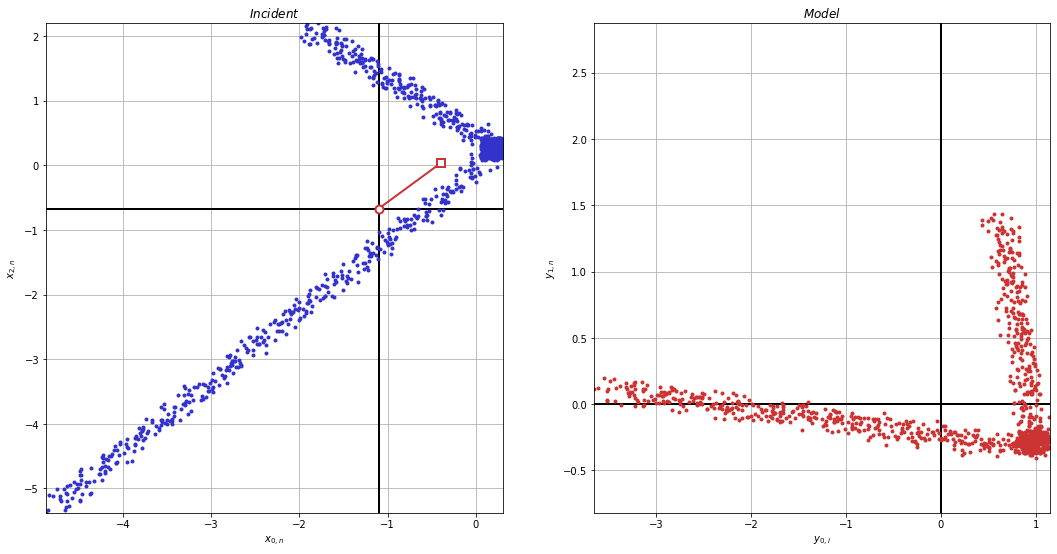

In [42]:
@ipywidgets.interact( )
def interface( noise = ipywidgets.FloatSlider( description = 'Noise', value = 0.05, min = 0.0, max = 0.5, step = 0.01, layout = { 'width' : '420px' } ) ) :

    """ Principal Component Model.    
        
        Arguments :
            noise : float - incident signal deviation.
    """
        
    length, valid = 1024, False
    while ( not valid ) :
        principalcomponentmodel = PrincipalComponentModel( )
        x = numpy.random.rand( 3, length ) - 0.5
        for _ in range( 0, 2 ) :
            jj = [ int( numpy.random.rand( ) * length * 0.5 ) ]
            jj += [ jj[ 0 ] + int( numpy.random.rand( ) * ( length - jj[ 0 ] - 1 ) ) + 1 ]
            jj = range( jj[ 0 ], jj[ 1 ] )
            x[ 0, jj ] += ( numpy.random.rand( ) - 0.5 ) * numpy.linspace( 0, len( jj ) - 1, len( jj ) ) * 10.0
            x[ 2, jj ] += ( numpy.random.rand( ) - 0.5 ) * x[ 0, jj ] + ( numpy.random.rand( ) - 0.5 ) * 10.0
        x = ( x.T / x.std( 1 ) ).T
        q = numpy.random.rand( x.shape[ 0 ], x.shape[ 1 ] ) - 0.5
        x += ( q.T * noise / q.std( 1 ) ).T
        x = ( x.T * ( numpy.random.rand( 3 ) + 1.0 ) + numpy.random.rand( 3 ) ).T
        y = principalcomponentmodel.model( x )
        valid = ( ( numpy.argsort( principalcomponentmodel.e ) == numpy.array( [ 1, 2, 0 ] ) ) ).all( )
    widget = [ ipywidgets.Dropdown( description = 'mean', value = str( principalcomponentmodel.u[ 0 ] ), options = [ str( x ) for x in principalcomponentmodel.u ], layout = { 'width' : '340px' } ),
               ipywidgets.Dropdown( description = 'eigenvalue', value = str( principalcomponentmodel.e[ 0 ] ), options = [ str( x ) for x in principalcomponentmodel.e ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )    
    widget = [ ipywidgets.Dropdown( description = 'deviation', value = str( principalcomponentmodel.s[ 0 ] ), options = [ str( x ) for x in principalcomponentmodel.s ], layout = { 'width' : '340px' } ), 
               ipywidgets.Dropdown( description = 'eigenvector', value = '  '.join( [ f'{x:1.5f}' for x in principalcomponentmodel.v[ 0, : ] ] ), options = [ '  '.join( [ f'{x:1.5f}' for x in principalcomponentmodel.v[ ii, : ] ] ) for ii in range( 0, 3 ) ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 1, 2, sharex = False, sharey = False, figsize = ( 18, 9 ) )[ 1 ]
    
    # Incident
    
    axes[ 0 ].plot( [ min( x[ 0, : ] ), max( x[ 0, : ] ) ], [ principalcomponentmodel.u[ 2 ], principalcomponentmodel.u[ 2 ] ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0 ].plot( [ principalcomponentmodel.u[ 0 ], principalcomponentmodel.u[ 0 ] ], [ min( x[ 2, : ] ), max( x[ 2, : ] ) ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0 ].plot( x[ 0, : ], x[ 2, : ], linestyle = 'None', marker = 'o', markeredgecolor = 'None', markeredgewidth = 2.0, markerfacecolor = [ 0.2, 0.2, 0.8 ], markersize = 4.0 )
    axes[ 0 ].plot( [ principalcomponentmodel.u[ 0 ], principalcomponentmodel.u[ 0 ] + principalcomponentmodel.v[ 0, 0 ] ], [ principalcomponentmodel.u[ 2 ], principalcomponentmodel.u[ 2 ] + principalcomponentmodel.v[ 0, 2 ] ], color = [ 0.8, 0.2, 0.2 ], linewidth = 2.0 )
    axes[ 0 ].plot( principalcomponentmodel.u[ 0 ], principalcomponentmodel.u[ 2 ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )
    axes[ 0 ].plot( principalcomponentmodel.u[ 0 ] + principalcomponentmodel.v[ 0, 0 ], principalcomponentmodel.u[ 2 ] + principalcomponentmodel.v[ 0, 2 ], linestyle = 'None', marker = 's', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )
    label( axes[ 0 ], r'$Incident$', r'$x_{0,n}$', r'$x_{2,n}$' )

    # Model
    
    axes[ 1 ].plot( [ 0.0, 0.0 ], [ min( y[ 1, : ] ) * 2.0, max( y[ 1, : ] ) * 2.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1 ].plot( [ min( y[ 0, : ] ), max( y[ 0, : ] ) ], [ 0.0, 0.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1 ].plot( [ 0.0, 0.0 ], [ min( y[ 1, : ] ) * 2.0, max( y[ 1, : ] ) * 2.0 ], color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 1 ].plot( y[ 0, : ], y[ 1, : ], linestyle = 'None', marker = 'o', markeredgecolor = 'None', markeredgewidth = 2.0, markerfacecolor = [ 0.8, 0.2, 0.2 ], markersize = 4.0 )
    label( axes[ 1 ], r'$Model$', r'$y_{0,i}$', r'$y_{1,n}$' )
    matplotlib.pyplot.show( )
    

In [44]:
@ipywidgets.interact( )
def interface( incident = ipywidgets.Dropdown( description = 'Incident', value = 'Drac Isere', options = [ 'Burning Eye', 'Drac Isere', 'Kali', 'Lionfish', 'Porsche', 'Riley' ], layout = { 'width' : '340px' } ),
               style = ipywidgets.Dropdown( description = 'Style', value = 'Haar', options = [ 'Coiflet', 'Daubechies', 'Haar', 'Symmlet' ], layout = { 'width' : '340px' } ),
               order = ipywidgets.IntSlider( description = 'Order', value = 1, min = 1, max = 29, step = 1, layout = { 'width' : '420px' } ),
               count = ipywidgets.IntSlider( description = 'Count', value = 2, min = 1, max = 4, step = 1, layout = { 'width' : '420px' } ),
               inverse = ipywidgets.IntSlider( description = 'Inverse', value = False, min = False, max = True, layout = { 'width' : '420px' } ) ) :

    """ Wavelet Transform.
       
        Arguments :
            incident : str - incident image in ( 'Burning Eye', Drac Isere', 'Kali', 'Lionfish', Porsche', 'Riley' ).
            style : str - in ( 'Coiflet', 'Daubechies', 'Haar', 'Symmlet' ).
            order : int.
            count : int.
            inverse : bool.
    """
    
    _order = { 'Coiflet' : numpy.array( [ 5, 11, 17, 23, 29 ] ),
               'Daubechies' : numpy.array( [ 3, 5, 7, 9, 11, 13, 15, 17, 19 ] ),
               'Haar' : numpy.array( [ 1 ] ),
               'Symmlet' : numpy.array( [ 7, 9, 11, 13, 15, 17, 19 ] ) }
    if ( order not in _order[ style ] ) :
        Log.write( 'ERROR', f'style = {style} Order = {str( _order[ style ] ).replace( "[", "[ " ).replace( "]", " ]" )}' )
        return
    wavelettransform = WaveletTransform( style, order )
    b = wavelettransform.b[ inverse ]
    widget = [ ipywidgets.Dropdown( description = 'b,l', value = str( b[ 0 ][ 0 ] ), options = [ str( x ) for x in b[ 0 ] ], layout = { 'width' : '340px' } ),
               ipywidgets.Dropdown( description = 'b,h', value = str( b[ 1 ][ 0 ] ), options = [ str( x ) for x in b[ 1 ] ], layout = { 'width' : '340px' } ) ]
    display( ipywidgets.VBox( children = widget, layout = ipywidgets.Layout( display = 'flex', flex_flow = 'row' ) ) )
    axes = matplotlib.pyplot.subplots( 2, 2, sharex = False, sharey = False, figsize = ( 18, 18 ) )[ 1 ]

    # Coefficients
    
    plot = [ ]
    x = Image.open( incident + '.png' ).convert( 'F' )
    cols, rows = x.size
    if ( ( rows % ( 2 ** count ) ) or ( cols % ( 2 ** count ) ) ) :
        Log.write( 'ERROR', f'Rows = {rows} Columns = {cols} Count = {count}' )
        return
    x = list( x.getdata( ) )
    x = numpy.array( [ x[ ii : ii + cols ] for ii in range( 0, rows * cols, cols ) ], 'float' )
    y = wavelettransform.transform( x, count, False )    
    if ( inverse ) :
        x, y = y, wavelettransform.transform( y, count, True )
        u, v = y, x
    else :
        u, v = x, y
    u[ :, : ] = ( u - u.min( ) ) * 255.0 / ( u.max( ) - u.min( ) )
    cols, rows = x.shape[ 1 ] // ( 2 ** count ), x.shape[ 0 ] // ( 2 ** count )
    q, v[ :, : ] = v[ : rows, : cols ], ( v - v[ rows :, cols : ].min( ) ) * 255.0 / ( v[ rows :, cols : ].max( ) - v[ rows :, cols : ].min( ) )
    v[ : rows, : cols ] = ( q - q.min( ) ) * 255.0 / ( q.max( ) - q.min( ) )
    n = numpy.linspace( 0, order, order + 1 )
    color = matplotlib.pyplot.get_cmap( 'gray' )
    axes[ 0, 0 ].plot( n, numpy.zeros( order + 1 ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 0 ].bar( n, b[ 0 ], color = [ 0.2, 0.2, 0.8 ], width = 0.006 * ( order + 1 ) )
    plot.append( axes[ 0, 0 ].plot( n, b[ 0 ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.2, 0.2, 0.8 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 0 ].bar( n, b[ 1 ], 0.005 * ( order + 1 ), color = [ 0.8, 0.2, 0.2 ] )
    plot.append( axes[ 0, 0 ].plot( n, b[ 1 ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = [ 1.0, 1.0, 1.0 ], markersize = 8.0 )[ 0 ] )
    axes[ 0, 0 ].legend( plot, ( r'$\vec{b_{L,n}}$', r'$\vec{b_{H,n}}$' ), loc = 'upper right' )    
    label( axes[ 0, 0 ], r'$Coefficients$', r'$n$' )
    
    # Response
    
    plot = [ ]
    h, f = FirFilter( b = b[ 0 ] ).response( )
    g, f = FirFilter( b = b[ 1 ] ).response( )    
    h = 20.0 * numpy.log10( numpy.maximum( abs( h ), numpy.finfo( float ).eps ) )
    g = 20.0 * numpy.log10( numpy.maximum( abs( g ), numpy.finfo( float ).eps ) )    
    axes[ 0, 1 ].plot( f, -3.0 * numpy.ones( len( h ) ), color = [ 0.0, 0.0, 0.0 ], linewidth = 2.0 )
    axes[ 0, 1 ].plot( [ -0.5, 0.5 ], [ -3.0, -3.0 ], linestyle = 'None', marker = 'o', markeredgecolor = [ 0.8, 0.2, 0.2 ], markeredgewidth = 2.0, markerfacecolor = 'None', markersize = 8.0 )
    plot.append( axes[ 0, 1 ].plot( f, h, color = [ 0.2, 0.2, 0.8 ], linewidth = 2.0 )[ 0 ] )
    plot.append( axes[ 0, 1 ].plot( f, g, color = [ 0.8, 0.2, 0.2 ], linewidth = 2.0 )[ 0 ] )
    axes[ 0, 1 ].legend( plot, ( r'$H_{L,f}$', r'$H_{H,f}$' ), loc = 'upper right' )
    label( axes[ 0, 1 ], r'$Response$', r'$f$', r'$H_f\ dB$' )
    
    # Incident
    
    axes[ 1, 0 ].imshow( x, cmap = color )
    label( axes[ 1, 0 ], r'$Incident$', r'$col$', r'$row$', False )

    # Transform
    
    axes[ 1, 1 ].imshow( y, cmap = color )
    label( axes[ 1, 1 ], r'$Transform$', r'$col$', r'$row$', False )
    matplotlib.pyplot.show( )
    

interactive(children=(Dropdown(description='Incident', index=1, layout=Layout(width='340px'), options=('Burnin…